<a href="https://colab.research.google.com/github/helene-78/Accidents/blob/main/regression_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE # Pour avoir 50 % de 0 et 50 % de 1 dans la colonne presence_accident
from sklearn.linear_model import LogisticRegression # Regression logistique
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold #KFold répété, pour 
from sklearn.model_selection import train_test_split
import seaborn as sns

**Importation du dataframe df_utiles traité dans prep_df_utiles.ipynb**

In [1]:
from google.colab import files
uploaded = files.upload()

Saving df_utiles.csv to df_utiles.csv


In [126]:
import io
df_utiles = pd.read_csv(io.BytesIO(uploaded['df_utiles.csv']))

**Traitement du csv df_utiles**

In [127]:
for i in df_utiles.index:
    if df_utiles["grav"][i] == 2:
        df_utiles["presence_deces"][i] = 1
df_utiles

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,jour,mois,an,hrmn,lum,dep,agg,int,atm,col,lat,long,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,catr,circ,nbv,vosp,prof,pr,pr1,plan,surf,infra,situ,vma,senc,catv,obs,obsm,choc,manv,motor,presence_deces
0,0,30,11,2019,60,4,93,1,1,1,2,"48,8962100","2,4701200",2,2,4,2,2002,0,1,0,-1,-1,-1,-1,1,3,10,0,1,6,900,2,1,2,1,70,2,7,0,2,5,23,1,0
1,1,30,11,2019,60,4,93,1,1,1,2,"48,8962100","2,4701200",1,1,4,2,1993,5,1,0,-1,-1,-1,-1,1,3,10,0,1,6,900,2,1,2,1,70,2,7,0,2,5,23,1,0
2,2,30,11,2019,60,4,93,1,1,1,2,"48,8962100","2,4701200",1,1,1,1,1959,0,1,0,-1,-1,-1,-1,1,3,10,0,1,6,900,2,1,2,1,70,2,17,1,0,3,11,1,0
3,3,30,11,2019,120,3,93,1,1,1,6,"48,9307000","2,3688000",1,1,4,2,1994,0,1,0,-1,-1,-1,-1,1,1,2,0,4,3,845,2,1,0,1,70,1,7,4,0,1,0,1,0
4,4,28,11,2019,900,1,92,1,1,1,4,"48,9358718","2,3191744",1,1,1,1,1996,0,1,0,-1,-1,0,-1,1,3,8,0,1,10,500,3,1,0,1,90,1,7,0,2,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132972,132972,27,11,2019,420,1,67,1,1,8,4,"48,5769000","7,7269000",1,1,4,2,1988,1,1,0,-1,-1,-1,-1,1,1,2,0,1,303,282,1,2,0,1,90,1,7,0,2,1,2,1,0
132973,132973,30,11,2019,120,4,94,1,1,1,6,"48,7717000","2,3457600",1,1,4,1,1998,9,1,0,-1,-1,-1,-1,1,3,3,0,1,5,199,1,1,0,1,90,2,7,3,0,1,21,0,0
132974,132974,30,11,2019,900,1,78,1,1,1,7,"48,7772890","2,2237590",1,1,3,1,1979,0,2,0,-1,-1,-1,-1,1,1,1,0,1,59,99,3,1,0,1,50,2,33,0,0,7,1,1,0
132975,132975,29,11,2019,1200,3,92,1,1,1,2,"48,8351236","2,1751101",1,1,4,1,1974,0,1,0,-1,-1,0,-1,1,1,3,0,1,6,699,1,1,0,2,110,1,10,0,2,4,0,2,0


In [17]:
df_utiles.columns

Index(['Unnamed: 0', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'agg', 'int',
       'atm', 'col', 'lat', 'long', 'place', 'catu', 'grav', 'sexe', 'an_nais',
       'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp', 'catr',
       'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'surf', 'infra',
       'situ', 'vma', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor',
       'presence_deces'],
      dtype='object')

**Analyse statistique des données de df_utiles.csv**

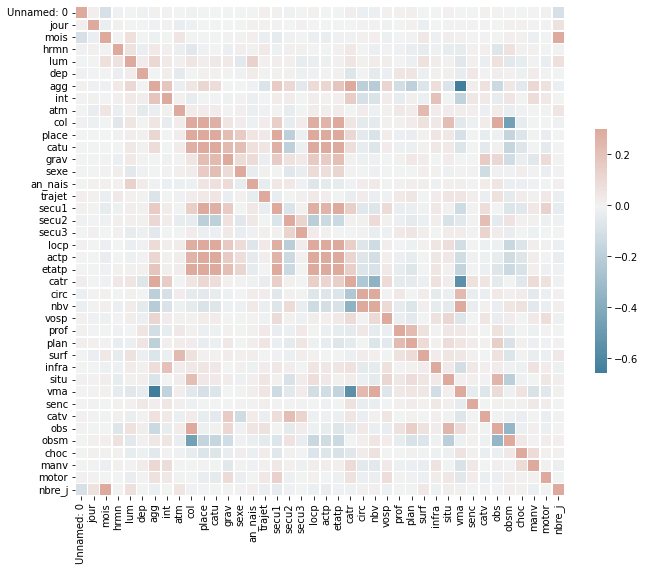

In [51]:
corr = df_utiles.drop(['an', 'presence_deces'], axis=1).corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Avant les prédictions : fonction qui calcule la distance de Haversine entre deux points de coordonnées géographiques connues (lat, long) -> permet de déterminer les accidents ayant eu lieu dans un rayon de X km autour du lieu choisi**

**Prédictions à l'aide d'une régression logistique**

In [115]:
from math import radians, cos, sin, asin, sqrt

coord = [2.16201, 48.708941] # Gif-sur-Yvette

def haversine(lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    coord[0], coord[1], lon2, lat2 = map(radians, [coord[0], coord[1], lon2, lat2])

    # haversine formula 
    dlon = lon2 - coord[0] 
    dlat = lat2 - coord[1] 
    a = sin(dlat/2)**2 + cos(coord[1]) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r
  
haversine(2.168658, 48.766828)

6.455176865644524

In [138]:
#df_utiles['lat'] = df_utiles['lat'].str.replace(',', '.').astype(float)
#df_utiles['long'] = df_utiles['long'].str.replace(',', '.').astype(float)
#df_regr_utiles = df_utiles.drop(['Unnamed: 0', 'gigajour', 'colonne_soustraction', 'jour', 'an', 'mois', 'pr', 'pr1'], axis=1)
df_regr_utiles = df_regr_utiles.dropna(axis=1)

# Récupération des accidents dans le rayon choisi

df_rayon = []
for i in df_regr_utiles.index:
  if haversine(df_regr_utiles["long"][i], df_regr_utiles["lat"][i]) <= 1:
    df_rayon.append(df_regr_utiles.iloc[i])

print(df_rayon[7])

X = df_regr_utiles.drop(['presence_deces'], axis=1).iloc[:, :38]
y = df_regr_utiles.iloc[:, 38] #colonne "presence_deces"
y = y.astype(int)
os = SMOTE(random_state=0) #Initialisation de SMOTE, pour avoir 50 % de 0 et 50 % de 1 dans y (sans modifier la distribution de l'échantillon d'accidents)
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1) #K-Fold répété, augmente la précision de l'algo de ~10 %
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train,y_train=os.fit_resample(X_train, y_train) #On applique OS initialisé plus tôt
#X_train = pd.DataFrame(data=X_train)
#y_train= pd.DataFrame(data=y_train)
logreg = LogisticRegression(solver='lbfgs') # Initialisation de la régression logistique
logreg.fit(X_train, y_train) # Fitting sur l'ensemble de train
y_pred = logreg.predict(X_test) # Prédictions
print(y_pred)
print(logreg.coef_)
print('Précision de la classification par régression logistique : ',logreg.score(X_test, y_test)*100,"%")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

hrmn                    420.0
lum                       3.0
dep                      67.0
agg                       1.0
int                       1.0
atm                       1.0
col                       1.0
lat               482878800.0
long               74575800.0
place                     1.0
catu                      1.0
grav                      1.0
sexe                      1.0
an_nais                1973.0
trajet                    4.0
secu1                     1.0
secu2                     8.0
secu3                    -1.0
locp                      0.0
actp                      0.0
etatp                    -1.0
catr                      3.0
circ                      2.0
nbv                       3.0
vosp                      0.0
prof                      2.0
plan                      1.0
surf                      1.0
infra                     2.0
situ                      1.0
vma                      80.0
senc                      3.0
catv                     10.0
obs       

**Test ARIMA pour anticiper nbre accidents**

In [25]:
pip install statsmodels

In [29]:
# ARIMA
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX

**But : obtenir la colonne nbre_acc_j qui représente le nombre d'accidents par jour**

[263 239 255 298 287 206 288 335 355 317 450 301 264 356 357 338 347 473
 345 230 330 275 257 313 337 327 226 276 299 318 313 427 288 250 304 294
 326 405 431 326 298 282 346 351 374 491 437 328 305 307 299 337 401 342
 275 367 366 323 311 308 257 251 259 309 304 346 343 303 290 295 299 305
 320 362 352 279 350 334 315 388 479 438 284 324 373 397 367 455 404 428
 302 365 324 435 415 355 285 313 306 376 355 422 419 312 284 319 373 382
 457 415 274 289 308 311 312 417 285 273 291 366 325 390 299 277 288 338
 367 279 297 406 325 321 430 423 395 339 353 308 274 307 292 387 363 421
 394 358 345 347 419 353 420 423 400 329 371 411 383 457 393 374 251 391
 412 368 441 382 451 424 403 367 394 571 453 388 436 397 445 442 540 469
 467 431 483 477 535 527 473 430 373 445 428 407 483 415 380 391 406 423
 365 432 443 336 288 341 376 385 415 393 249 354 362 289 353 444 323 303
 349 321 354 311 416 339 305 270 335 316 220 314 381 342 270 295 280 340
 347 368 384 295 291 302 400 430 459 312 343 370 37

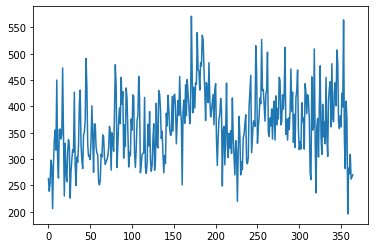

In [31]:
from datetime import date
df_utiles = pd.read_csv('df_utiles.csv')
# la colonne "gigajour" contient la date au format standard dd/mm/yyyy
df_utiles["gigajour"] = 0 # Initialisation de la colonne
df_utiles["gigajour"] = df_utiles["jour"].astype(str)+'/'+df_utiles["mois"].astype(str)+'/'+df_utiles["an"].astype(str)
df_utiles["gigajour"] = pd.to_datetime(df_utiles["gigajour"], format="%d/%m/%Y")
df_utiles["colonne_soustraction"] = date(df_utiles["an"].iloc[0], 1, 1) # Création d'une colonne remplie avec la date du 01/01/2019
df_utiles["colonne_soustraction"] = pd.to_datetime(df_utiles["colonne_soustraction"])
df_utiles["nbre_j"] = df_utiles["gigajour"] - df_utiles["colonne_soustraction"] # Permet d'obtenir une colonne contenant, pour chaque accident,
# Le nombre de jours écoulés depuis le 01/01/2019
def datification(x):
    return x.days
df_utiles["nbre_j"] = df_utiles["nbre_j"].apply(datification)
nbre_acc_j = df_utiles.groupby(['nbre_j']).agg('count').jour.values #Nbre d'accidents par jour
print(nbre_acc_j)
ts = pd.Series(nbre_acc_j, index=pd.date_range("1/1/2019", periods=365))
print(ts)
plt.plot([i for i in range(365)], nbre_acc_j)

**SARIMAX : prédire nbre d'accidents en s'appuyant sur les données déjà enregistrées**

**Graphe d'autocorrélation**

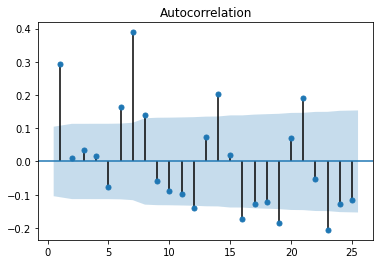

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

# Subtract the rolling mean
nbre_acc_j_dataframe = pd.DataFrame(nbre_acc_j)
nbre_acc_rolling = nbre_acc_j_dataframe - nbre_acc_j_dataframe.rolling(15).mean()

# Drop the NaN values
nbre_acc_rolling = nbre_acc_rolling.dropna()

# Create figure and subplots
fig, ax1 = plt.subplots()

# Plot the ACF
plot_acf(nbre_acc_rolling, lags=25, zero=False, ax=ax1);

Conclusion : la composante saisonale a pour période 7 (abscisse du max sur le plot ci-dessus)

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create a SARIMAX model
model = SARIMAX(nbre_acc_j, order=(31, 0, 0), seasonal_order=(1, 1, 0, 7)) # Le 7 correspond à la période déterminée ci-dessus

# Fit the model
results = model.fit()

# Print the results summary
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(31, 0, 0)x(1, 1, 0, 7)   Log Likelihood               -1883.040
Date:                            Sun, 12 Dec 2021   AIC                           3832.080
Time:                                    13:08:32   BIC                           3960.138
Sample:                                         0   HQIC                          3883.009
                                            - 365                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3079      0.061      5.041      0.000       0.188       0.428
ar.L2          0.1580      0.061      2.602      0.009       0.039       0.277
ar.L3          0.0551      0.059      0.938      0.348      -0.060       0.170
ar.L4          0.0804      0.065      1.246      0.213      -0.046       0.207
ar.L5          0.0384      0.061      0.626      0.531      -0.082       0.158
ar.L6          0.1137      0.058      1.973      0.048       0.001       0.227
ar.L7         -0.1288      0.156     -0.827      0.408      -0.434       0.176
ar.L8          0.1168      0.075      1.565      0.118      -0.030       0.263
ar.L9          0.1346      0.067      2.006      0.045       0.003       0.266
ar.L10        -0.0770      0.067     -1.154      0.249      -0.208       0.054
ar.L11         0.0168      0.063      0.266      0.790      -0.107       0.140
ar.L12         0.0248      0.064      0.390      0.697      -0.100       0.149
ar.L13         0.0738      0.062      1.186      0.236      -0.048       0.196
ar.L14        -0.5718      0.102     -5.605      0.000      -0.772      -0.372
ar.L15         0.1087      0.073      1.484      0.138      -0.035       0.252
ar.L16         0.0923      0.077      1.202      0.229      -0.058       0.243
ar.L17        -0.0508      0.076     -0.669      0.503      -0.200       0.098
ar.L18         0.0321      0.067      0.481      0.631      -0.099       0.163
ar.L19        -0.0185      0.065     -0.284      0.777      -0.147       0.109
ar.L20         0.1601      0.060      2.675      0.007       0.043       0.277
ar.L21        -0.1893      0.112     -1.684      0.092      -0.410       0.031
ar.L22        -0.0548      0.069     -0.796      0.426      -0.190       0.080
ar.L23         0.0993      0.070      1.410      0.159      -0.039       0.237
ar.L24        -0.0321      0.069     -0.466      0.641      -0.167       0.103
ar.L25         0.0675      0.062      1.092      0.275      -0.054       0.189
ar.L26         0.0741      0.064      1.150      0.250      -0.052       0.201
ar.L27         0.0359      0.070      0.513      0.608      -0.101       0.173
ar.L28        -0.1951      0.081     -2.421      0.015      -0.353      -0.037
ar.L29         0.0099      0.072      0.138      0.891      -0.131       0.151
ar.L30         0.1232      0.069      1.791      0.073      -0.012       0.258
ar.L31        -0.1206      0.063     -1.921      0.055      -0.244       0.002
ar.S.L7       -0.5701      0.153     -3.718      0.000      -0.871      -0.270
sigma2      2121.9601    162.579     13.052      0.000    1803.311    2440.610
===================================================================================
Ljung-Box (Q):                       20.10   Jarque-Bera (JB):                12.86
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              

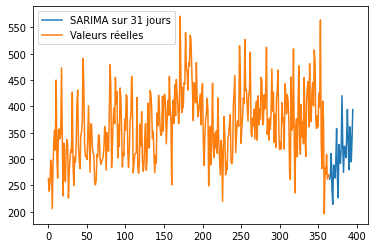

In [47]:
results_pred = results.get_forecast(31)
results_mean = results_pred.predicted_mean
plt.plot([i for i in range(365,396)], results_mean, label='SARIMA sur 31 jours')
plt.plot(nbre_acc_j_dataframe, label='Valeurs réelles')
plt.legend()